## Bivariate Analysis, Multiple Linear Regression, LDA, QDA, Feature Selection

Dataset: `group_23.csv`


In [ ]:
# Install dependencies into this Jupyter kernel (run once)
%pip install -q matplotlib seaborn scikit-learn numpy pandas


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Imports & setup
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report

# Regression/feature selection
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegressionCV
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.feature_selection import SelectFromModel

# Discriminant analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plot style
sns.set(style="whitegrid", context="notebook")


In [3]:
# Load dataset
CSV_PATH = "group_23.csv"
df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
print("Columns:")
print(list(df.columns))

# Targets per assignment
TARGET_CLASS = "target_class"
TARGET_REG = "target_regression"

# Basic checks
assert TARGET_CLASS in df.columns and TARGET_REG in df.columns, "Target columns not found in dataset"

# Identify numeric feature columns only (exclude targets)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols_reg = [c for c in numeric_cols if c != TARGET_REG]  # keep numeric predictors for regression

# For classification we will also use numeric feature set; target_class is categorical already
feature_cols_cls = [c for c in numeric_cols if c not in [TARGET_REG]]

print("\nNumeric feature count (reg):", len(feature_cols_reg))
print("Numeric feature count (cls):", len(feature_cols_cls))

# Peek
display(df.head(3))


Shape: (3000, 49)
Columns:
['duration_1', 'duration_2', 'duration_3', 'duration_4', 'duration_5', 'loudness_level', 'popularity_level', 'tempo_class', 'time_signature', 'key_mode', 'artist_song_count', 'album_freq', 'movement_index', 'intensity_level', 'verbal_density', 'purity_score', 'positivity_index', 'activity_rate', 'loudness_intensity', 'happy_dance', 'acoustics_instrumental', 'artists_avg_popularity', 'tempo_vs_genre', 'energy_rank_pct', 'loud_energy_ratio', 'mood_pca', 'mood_cluster', 'acoustic_valence_mood_cluster', 'explicit', 'signal_strength', 'mode_indicator', 'focus_factor', 'ambient_level', 'key_sin', 'key_cos', 'duration_log', 'duration_log_z', 'time_signature_class_boolean', 'loudness_yeo', 'is_instrumental', 'is_dance_hit', 'temp_zscore', 'resonance_factor', 'timbre_index', 'echo_constant', 'distorted_movement', 'signal_power', 'target_class', 'target_regression']

Numeric feature count (reg): 46
Numeric feature count (cls): 46


,duration_1,duration_2,duration_3,duration_4,duration_5,loudness_level,popularity_level,tempo_class,time_signature,key_mode,...,is_instrumental,is_dance_hit,temp_zscore,resonance_factor,timbre_index,echo_constant,distorted_movement,signal_power,target_class,target_regression
0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,0.221824,0.485996,...,0.0,0.0,0.097514,-2.438714,0.774256,1,-0.039187,0.789,class_69,-1.131539
1,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,0.221824,0.739248,...,0.0,0.0,-0.939303,-0.615927,0.118441,1,-1.612293,0.860,class_69,-1.490205
2,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,0.221824,0.485996,...,0.0,0.0,-1.071032,-1.345330,0.449030,1,0.243165,0.855,class_69,-1.266039


## Bivariate Analysis

Goals:
- Relationship of each feature with `target_regression` (Pearson correlation).
- Relationship of each feature with `target_class` (ANOVA F-score).
- Visualize top relationships.


Top 15 |corr| with target_regression:


,abs_corr
artists_avg_popularity,0.879063
album_freq,0.639828
popularity_level,0.535562
movement_index,0.210674
loudness_intensity,0.200283
artist_song_count,0.185818
mood_cluster,0.143329
energy_rank_pct,0.125562
positivity_index,0.125460
ambient_level,0.114526


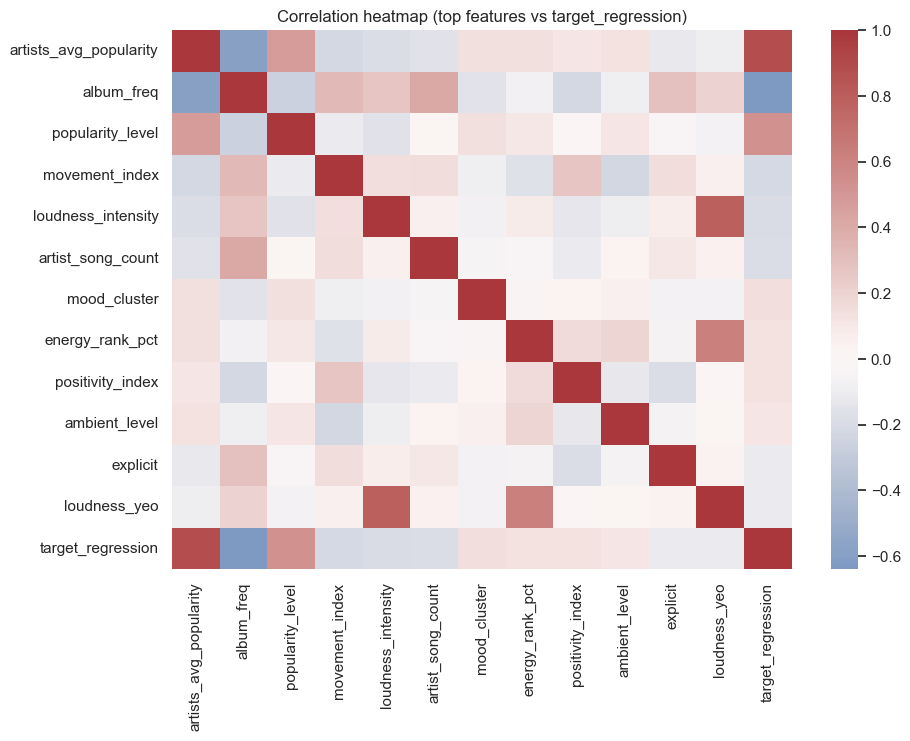

Top 15 ANOVA F-scores vs target_class:


,feature,f_value,p_value
11,album_freq,1665.314051,0.000000e+00
15,purity_score,967.469681,0.000000e+00
21,artists_avg_popularity,817.240340,5.418499e-284
6,popularity_level,399.035229,2.260211e-154
27,acoustic_valence_mood_cluster,376.378157,1.484298e-146
34,duration_log,365.559480,8.663160e-143
35,duration_log_z,365.559480,8.663160e-143
12,movement_index,338.858676,2.123294e-133
16,positivity_index,236.597856,3.932441e-96
18,loudness_intensity,222.692729,6.778382e-91


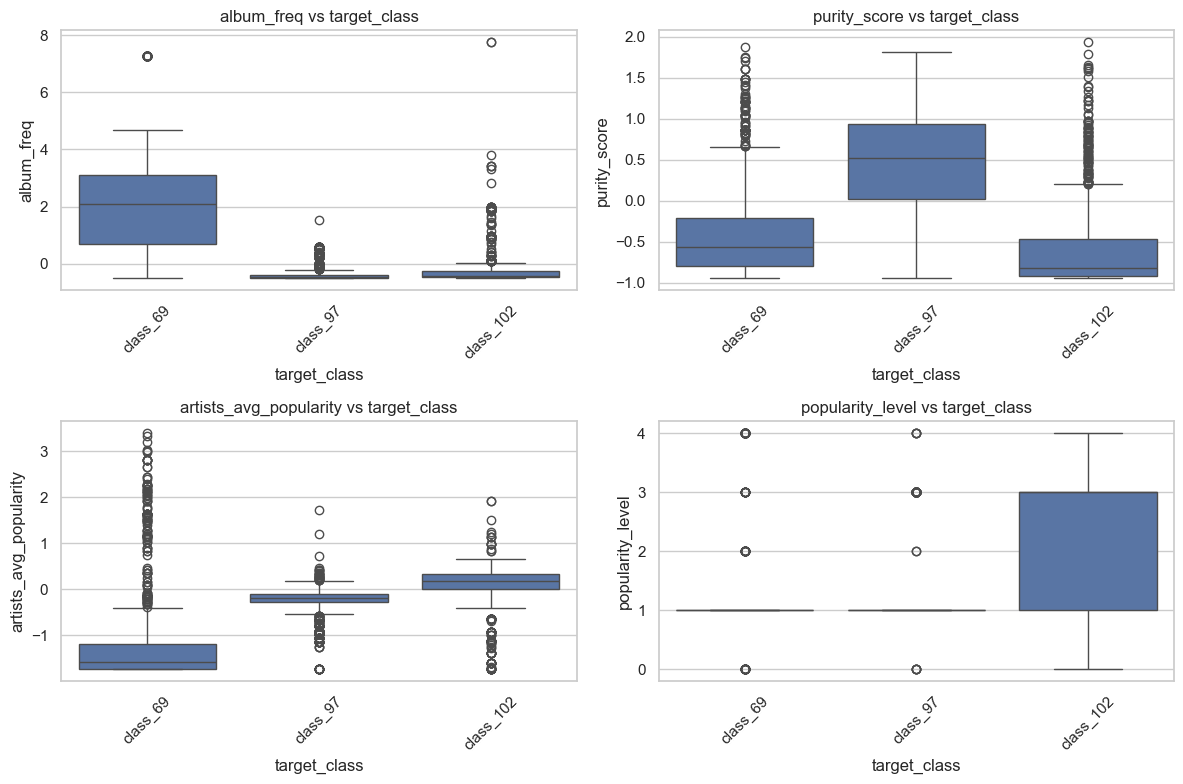

In [4]:
# Correlation with target_regression
corr_with_reg = df[feature_cols_reg + [TARGET_REG]].corr(numeric_only=True)[TARGET_REG].drop(TARGET_REG)

topN = 15
corr_sorted = corr_with_reg.abs().sort_values(ascending=False)
print("Top", topN, "|corr| with target_regression:")
display(corr_sorted.head(topN).to_frame("abs_corr"))

# Heatmap of top correlated features
top_features_for_heatmap = corr_sorted.head(min(topN, 12)).index.tolist()
plt.figure(figsize=(10, 7))
sns.heatmap(df[top_features_for_heatmap + [TARGET_REG]].corr(), cmap="vlag", center=0, annot=False)
plt.title("Correlation heatmap (top features vs target_regression)")
plt.show()

# ANOVA F-score for classification target
X_num = df[feature_cols_cls].values
y_cls = df[TARGET_CLASS].astype(str).values

f_vals, p_vals = f_classif(X_num, y_cls)
score_df = pd.DataFrame({
    "feature": feature_cols_cls,
    "f_value": f_vals,
    "p_value": p_vals
}).sort_values("f_value", ascending=False)

print("Top", topN, "ANOVA F-scores vs target_class:")
display(score_df.head(topN))

# Boxplots for top 4 ANOVA features
top4 = score_df.head(4)["feature"].tolist()
if len(top4) >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.ravel()
    for i, feat in enumerate(top4):
        sns.boxplot(data=df, x=TARGET_CLASS, y=feat, ax=axes[i])
        axes[i].set_title(f"{feat} vs {TARGET_CLASS}")
        axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()


## Multiple Linear Regression — target_regression

- Baseline: Linear Regression with all numeric features.
- Feature selection: SelectKBest with `f_regression` (grid over k), evaluated with 5-fold CV to pick k.
- Final evaluation on holdout test set.
- Metrics: R², MAE, RMSE.


In [5]:
# Prepare data
X_reg = df[feature_cols_reg].copy()
y_reg = df[TARGET_REG].copy()

# Train/test split
Xtr, Xte, ytr, yte = train_test_split(X_reg, y_reg, test_size=0.2, random_state=RANDOM_STATE)

# Baseline: all features
baseline_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("model", LinearRegression())
])

baseline_pipe.fit(Xtr, ytr)
yhat_base = baseline_pipe.predict(Xte)

def_reg_metrics = {
    "R2": r2_score(yte, yhat_base),
    "MAE": mean_absolute_error(yte, yhat_base),
    "RMSE": float(np.sqrt(mean_squared_error(yte, yhat_base))),
}

print("Baseline (all features):")
for k, v in def_reg_metrics.items():
    print(f"  {k}: {v:.4f}")

# Feature selection + Linear Regression
k_grid = [5, 10, 20, 40, 80, min(120, Xtr.shape[1])]
# Deduplicate and ensure valid
k_grid = sorted({k for k in k_grid if 1 <= k <= Xtr.shape[1]})

best_cv = -np.inf
best_k = None
for k in k_grid:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("select", SelectKBest(score_func=f_regression, k=k)),
        ("model", LinearRegression())
    ])
    cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(pipe, Xtr, ytr, cv=cv, scoring="r2")
    mean_r2 = scores.mean()
    if mean_r2 > best_cv:
        best_cv = mean_r2
        best_k = k

print(f"\nSelectKBest search — best k={best_k} (CV R²={best_cv:.4f})")

best_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_regression, k=best_k)),
    ("model", LinearRegression())
])

best_pipe.fit(Xtr, ytr)
yhat_best = best_pipe.predict(Xte)

sel_reg_metrics = {
    "R2": r2_score(yte, yhat_best),
    "MAE": mean_absolute_error(yte, yhat_best),
    "RMSE": float(np.sqrt(mean_squared_error(yte, yhat_best))),
}

print("\nMultiple Linear Regression (SelectKBest):")
for k, v in sel_reg_metrics.items():
    print(f"  {k}: {v:.4f}")

# Compare succinctly
comp_df = pd.DataFrame({
    "metric": ["R2", "MAE", "RMSE"],
    "baseline": [def_reg_metrics["R2"], def_reg_metrics["MAE"], def_reg_metrics["RMSE"]],
    "selectKBest": [sel_reg_metrics["R2"], sel_reg_metrics["MAE"], sel_reg_metrics["RMSE"]]
})
display(comp_df)


Baseline (all features):
  R2: 0.8297
  MAE: 0.2143
  RMSE: 0.3594

SelectKBest search — best k=5 (CV R²=0.8054)

Multiple Linear Regression (SelectKBest):
  R2: 0.8343
  MAE: 0.2096
  RMSE: 0.3545


,metric,baseline,selectKBest
0,R2,0.829664,0.834272
1,MAE,0.214281,0.209639
2,RMSE,0.359387,0.354492


## Classification — LDA and QDA

Resampling strategies evaluated:
- Holdout (80/20)
- Cross-validation (k=5 and k=10)
- Leave-One-Out Cross-Validation (LOOCV)
- Bootstrap (out-of-bag accuracy)

Metrics reported: Accuracy and Macro-F1.


In [6]:
# Prepare classification data
X_cls = df[feature_cols_cls].copy()
y_cls = df[TARGET_CLASS].astype(str).copy()

Xtr_c, Xte_c, ytr_c, yte_c = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=RANDOM_STATE, stratify=y_cls
)

scaler = StandardScaler()

lda_clf = LDA()
qda_clf = QDA(reg_param=0.0)  # reg_param can be tuned if needed

from sklearn.base import clone

def evaluate_holdout(clf, Xtr, ytr, Xte, yte):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", clf)
    ])
    pipe.fit(Xtr, ytr)
    yhat = pipe.predict(Xte)
    return {
        "accuracy": accuracy_score(yte, yhat),
        "f1_macro": f1_score(yte, yhat, average="macro"),
    }

def evaluate_cv(clf, X, y, k):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", clf)
    ])
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=RANDOM_STATE)
    acc = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy").mean()
    f1m = cross_val_score(pipe, X, y, cv=cv, scoring="f1_macro").mean()
    return {"cv_acc": acc, "cv_f1_macro": f1m}

def evaluate_loocv(clf, X, y, max_n=1500):
    # If dataset is large, sample to limit runtime while keeping class balance
    X_use, y_use = X, y
    if X.shape[0] > max_n:
        # stratified subsample
        from sklearn.model_selection import StratifiedShuffleSplit
        sss = StratifiedShuffleSplit(n_splits=1, test_size=(X.shape[0]-max_n)/X.shape[0], random_state=RANDOM_STATE)
        for train_idx, _ in sss.split(X, y):
            X_use, y_use = X.iloc[train_idx], y.iloc[train_idx]
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", clf)
    ])
    loo = LeaveOneOut()
    acc = cross_val_score(pipe, X_use, y_use, cv=loo, scoring="accuracy").mean()
    return {"loocv_acc": acc, "n_used": X_use.shape[0]}

def bootstrap_oob_accuracy(clf, X, y, B=100):
    rng = np.random.RandomState(RANDOM_STATE)
    n = X.shape[0]
    oob_scores = []
    for _ in range(B):
        idx = rng.randint(0, n, n)
        oob = np.setdiff1d(np.arange(n), np.unique(idx))
        if len(oob) == 0:
            continue
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("model", clone(clf))
        ])
        pipe.fit(X.iloc[idx], y.iloc[idx])
        yhat = pipe.predict(X.iloc[oob])
        oob_scores.append(accuracy_score(y.iloc[oob], yhat))
    return {"bootstrap_oob_acc_mean": float(np.mean(oob_scores)), "B_effective": int(len(oob_scores))}

results_cls = {}

# LDA evaluations
results_cls["LDA_holdout"] = evaluate_holdout(lda_clf, Xtr_c, ytr_c, Xte_c, yte_c)
results_cls["LDA_cv5"] = evaluate_cv(lda_clf, X_cls, y_cls, 5)
results_cls["LDA_cv10"] = evaluate_cv(lda_clf, X_cls, y_cls, 10)
results_cls["LDA_loocv"] = evaluate_loocv(lda_clf, X_cls, y_cls)
results_cls["LDA_bootstrap"] = bootstrap_oob_accuracy(lda_clf, X_cls, y_cls, B=120)

# QDA evaluations
results_cls["QDA_holdout"] = evaluate_holdout(qda_clf, Xtr_c, ytr_c, Xte_c, yte_c)
results_cls["QDA_cv5"] = evaluate_cv(qda_clf, X_cls, y_cls, 5)
results_cls["QDA_cv10"] = evaluate_cv(qda_clf, X_cls, y_cls, 10)
results_cls["QDA_loocv"] = evaluate_loocv(qda_clf, X_cls, y_cls)
results_cls["QDA_bootstrap"] = bootstrap_oob_accuracy(qda_clf, X_cls, y_cls, B=120)

pd.set_option("display.precision", 4)
display(pd.DataFrame(results_cls))


,LDA_holdout,LDA_cv5,LDA_cv10,LDA_loocv,LDA_bootstrap,QDA_holdout,QDA_cv5,QDA_cv10,QDA_loocv,QDA_bootstrap
accuracy,0.9650,NaN,NaN,NaN,NaN,0.8867,NaN,NaN,NaN,NaN
f1_macro,0.9649,NaN,NaN,NaN,NaN,0.8833,NaN,NaN,NaN,NaN
cv_acc,NaN,0.9687,0.964,NaN,NaN,NaN,0.9580,0.9453,NaN,NaN
cv_f1_macro,NaN,0.9686,0.964,NaN,NaN,NaN,0.9579,0.9450,NaN,NaN
loocv_acc,NaN,NaN,NaN,0.988,NaN,NaN,NaN,NaN,0.9427,NaN
n_used,NaN,NaN,NaN,1500.000,NaN,NaN,NaN,NaN,1500.0000,NaN
bootstrap_oob_acc_mean,NaN,NaN,NaN,NaN,0.9704,NaN,NaN,NaN,NaN,0.9631
B_effective,NaN,NaN,NaN,NaN,120.0000,NaN,NaN,NaN,NaN,120.0000


## Feature Selection for Classification (Regularization)

- Use L1-penalized Logistic Regression to select features.
- Refit LDA and QDA on selected subset and compare to using all features.


In [7]:
# L1 logistic for feature selection
# Standardize then logistic with L1 using saga
lr_l1 = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegressionCV(
        Cs=10,
        penalty="l1",
        solver="saga",
        multi_class="auto",
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
        scoring="accuracy",
        max_iter=5000,
        n_jobs=None,
        refit=True
    ))
])

lr_l1.fit(Xtr_c, ytr_c)
logreg = lr_l1.named_steps["logreg"]
coefs = logreg.coef_

# Determine selected features: non-zero coefficient in any class
if coefs.ndim == 1:
    nonzero = np.abs(coefs) > 1e-9
else:
    nonzero = np.abs(coefs).max(axis=0) > 1e-9
selected_mask = nonzero
selected_features = np.array(Xtr_c.columns)[selected_mask]

print(f"Selected features (L1 logistic): {len(selected_features)} / {Xtr_c.shape[1]}")

# Evaluate LDA/QDA using only selected features
Xtr_sel = Xtr_c[selected_features]
Xte_sel = Xte_c[selected_features]

lda_sel = evaluate_holdout(lda_clf, Xtr_sel, ytr_c, Xte_sel, yte_c)
qda_sel = evaluate_holdout(qda_clf, Xtr_sel, ytr_c, Xte_sel, yte_c)

# Baselines on all features for comparison
lda_all = evaluate_holdout(lda_clf, Xtr_c, ytr_c, Xte_c, yte_c)
qda_all = evaluate_holdout(qda_clf, Xtr_c, ytr_c, Xte_c, yte_c)

compare_cls = pd.DataFrame({
    "LDA_all": lda_all,
    "LDA_L1_selected": lda_sel,
    "QDA_all": qda_all,
    "QDA_L1_selected": qda_sel,
})

display(compare_cls)


Selected features (L1 logistic): 39 / 46


,LDA_all,LDA_L1_selected,QDA_all,QDA_L1_selected
accuracy,0.9650,0.9617,0.8867,0.8950
f1_macro,0.9649,0.9616,0.8833,0.8927


## Conclusões (resumo)

- Bivariada: correlações com `target_regression` e ANOVA vs `target_class`.
- Regressão múltipla: baseline vs seleção de features (k escolhido por CV); métricas R², MAE, RMSE no holdout.
- Classificação (LDA/QDA): holdout, CV (5/10), LOOCV, bootstrap.
- Regularização: seleção L1 (logística) e reavaliação com subconjunto de features.
